In [1]:
import os
import pandas as pd

from quandl_wrapper import quandl_get


### Get list of unique state codes

In [2]:
state_codes = []

with open('./seds_tpopp_all_states.txt', 'r') as f:
    for line in f:
        per_state_code = line.split('::')[0]
        state_code = per_state_code.rsplit('_',2)[1]
        if state_code == 'US':
            continue
        state_codes.append(state_code)

print(len(state_codes))
state_codes[:5]


51


['MO', 'MN', 'MI', 'ME', 'MD']

## Try Quandle energy consumption parsing

In [3]:
energy_consumption_pc_ca = quandl_get("EIA/SEDS_TETPB_CA_A")
energy_consumption_pc_ca.head()

,Value
Date,
1960-12-31,217.4
1961-12-31,218.8
1962-12-31,218.1
1963-12-31,222.1
1964-12-31,232.5


In [5]:
energy_consumption_per_state = []
for state in state_codes:
    try:
        energy_consumption = quandl_get(f"EIA/SEDS_TETPB_{state}_A")
        energy_consumption_per_state.append(energy_consumption.rename(columns={'Value':state}))
    except:
        print(f'failed: {state}')

energy_consumption_total = pd.concat(energy_consumption_per_state, axis=1, ignore_index=False)
# Set index to year
energy_consumption_total = energy_consumption_total.set_index(keys=energy_consumption_total.index.year)

print(energy_consumption_total.shape)
energy_consumption_total.head()

(60, 51)


,MO,MN,MI,ME,MD,MA,LA,KY,KS,IN,...,WI,WA,VT,VA,UT,CA,AZ,AR,AL,AK
Date,,,,,,,,,,,,,,,,,,,,,
1960,208.0,211.1,236.4,238.3,224.0,204.3,460.8,270.7,289.2,327.4,...,215.6,282.8,176.2,213.6,336.9,217.4,214.2,238.1,264.7,268.3
1961,206.6,209.9,237.8,246.1,220.4,206.9,476.1,268.1,279.1,327.9,...,218.8,285.7,184.5,208.7,321.4,218.8,216.7,239.0,250.7,303.2
1962,215.7,218.2,250.2,239.3,229.4,211.3,472.4,271.7,286.6,333.8,...,226.7,292.3,190.3,211.4,323.9,218.1,220.9,246.5,265.2,320.4
1963,217.3,219.7,257.2,243.1,229.0,202.7,517.4,286.9,289.1,340.7,...,228.6,304.8,187.9,219.8,320.1,222.1,229.0,258.5,271.9,315.6
1964,222.7,229.4,261.4,244.4,235.9,205.5,541.6,284.5,297.5,353.1,...,234.1,324.7,180.6,222.5,342.1,232.5,237.6,277.9,288.4,323.4


## Try some Bokeh maps

In [6]:
energy_consumption_long = energy_consumption_total.stack().to_frame().reset_index()
energy_consumption_long.columns = ['year','state','energy_consumption']
energy_consumption_long.head()

,year,state,energy_consumption
0,1960,MO,208.0
1,1960,MN,211.1
2,1960,MI,236.4
3,1960,ME,238.3
4,1960,MD,224.0


In [7]:
from bokeh.io import show, output_notebook
from bokeh.models import LogColorMapper, ColumnDataSource
from bokeh.palettes import OrRd8 as palette
from bokeh.plotting import figure

from bokeh.models.callbacks import CustomJS

from bokeh.sampledata.unemployment import data as unemployment
from bokeh.sampledata.us_counties import data as counties
from bokeh.sampledata.us_states import data as states

output_notebook()

palette = tuple(reversed(palette))

state_xs = [state["lons"] for state in states.values()]
state_ys = [state["lats"] for state in states.values()]

state_names = [state['name'] for state in states.values()]
state_rates = [energy_consumption_total[state][2019] for state in state_codes]
color_mapper = LogColorMapper(palette=palette)

data=dict(
    x=state_xs,
    y=state_ys,
    name=state_names,
    rate=state_rates,
)

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="US energy consumption, 2019", tools=TOOLS,
    x_axis_location=None, y_axis_location=None,
    plot_width=300, plot_height=300,
    tooltips=[
        ("Name", "@name"), ("Energy consumption per capita", "@energy{0.00}"), ("(Long, Lat)", "($x, $y)")
    ])
p.grid.grid_line_color = None
p.hover.point_policy = "follow_mouse"

p.patches('x', 'y', source=data,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

show(p)


Loading BokehJS ...

In [8]:
source = ColumnDataSource(energy_consumption_long.query("year==2019"))

In [9]:
source.data['energy_consumption']

array([293.8, 336.9, 288.7, 285.1, 223.4, 212.9, 921.9, 385.3, 385.6,
       412.6, 312.5, 314.9, 517.3, 217.2, 278.8, 203.6, 303.6, 236.7,
       206.4, 273.8, 490.8, 317.8, 452.8, 315.7, 179.8, 298.1, 243.8,
       423.1, 310.7, 198.1, 250.4, 350.3, 236.3, 235. , 466. , 874.6,
       252.6, 416.9, 364.8, 932.3, 460.7, 317. , 272.7, 219.3, 282.7,
       266.8, 197.8, 212.6, 362.4, 391.8, 838.5])

## Use bokeh to plot 1 year of energy consumption data

In [10]:
import geopandas as gpd

In [11]:
contiguous_usa = gpd.read_file('shapefiles/cb_2020_us_state_20m.shp')

In [12]:
contiguous_usa.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,06,01779778,0400000US06,06,CA,California,00,403671196038,20294133830,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847..."
1,55,01779806,0400000US55,55,WI,Wisconsin,00,140292246684,29343721650,"MULTIPOLYGON (((-86.93428 45.42115, -86.83575 ..."
2,16,01779783,0400000US16,16,ID,Idaho,00,214049923496,2391577745,"POLYGON ((-117.24303 44.39097, -117.21507 44.4..."
3,27,00662849,0400000US27,27,MN,Minnesota,00,206232157570,18949864226,"POLYGON ((-97.22904 49.00069, -96.93096 48.999..."
4,19,01779785,0400000US19,19,IA,Iowa,00,144659688848,1085996889,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."


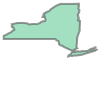

In [13]:
contiguous_usa.set_index('STUSPS').loc['NY']['geometry']

In [14]:
energy_consumption_long_geo = contiguous_usa.merge(energy_consumption_long[['year','state','energy_consumption']],
    right_on = 'state',
    left_on = 'STUSPS'
)

In [15]:
ecl = energy_consumption_long_geo.query("year==2019").query("state not in ['AK','HI']")

source_2019 = ColumnDataSource(ecl)

In [16]:
from bokeh.models import LinearColorMapper,GeoJSONDataSource, HoverTool

In [17]:
color_mapper = LinearColorMapper(palette=palette)

geosource = GeoJSONDataSource(geojson = ecl.to_json())

In [18]:
p = figure(title = 'Energy Consumption per Capita, 2019',
           plot_width=950,
           plot_height=600)

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.hover.point_policy = "follow_mouse"


state_patches = p.patches('xs','ys', source = geosource,
                          fill_color={'field': 'energy_consumption', 'transform': color_mapper},
                          line_color='black',
                          line_width=0.3,
                          fill_alpha=1
        )

# Create hover tool
p.add_tools(HoverTool(renderers = [state_patches],
                      tooltips = [('State','@NAME'),
                                ('Energy Consumption','@energy_consumption{0.00}k')]))

show(p)

## Add a slider for the years

In [19]:
from bokeh.models import Slider, Label
from bokeh.layouts import row, column
from bokeh.io import curdoc

In [20]:
years = sorted(energy_consumption_long_geo.year.unique().tolist())

In [21]:
data = {}

for year in years:
    df_year = (energy_consumption_long_geo
               .query(f'year=={year}')
               .query("state not in ['AK','HI']")
               .reset_index(drop=True)
               .to_json()
              )
    data[year] = df_year

In [22]:
geosource_year0 = GeoJSONDataSource(geojson = data[years[0]])

In [23]:
p = figure(title = 'Energy Consumption per Capita',
           plot_width=950,
           plot_height=500)

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.hover.point_policy = "follow_mouse"

label = Label(x=-124, y=25, text=str(years[0]), text_font_size='45px', text_color='#eeeeee')
p.add_layout(label)


state_patches = p.patches('xs','ys', source = geosource_year0,
                          fill_color={'field': 'energy_consumption', 'transform': color_mapper},
                          line_color='black',
                          line_width=0.3,
                          fill_alpha=1
        )

# Create hover tool
p.add_tools(HoverTool(renderers = [state_patches],
                      tooltips = [('State','@NAME'),
                                  ('Energy Consumption','@energy_consumption{0.00}k'),
                                  ('Year', '@year')
                                 ]))


# define slider behaviour -- Python callback doesn't work in notebook
# def slider_update(attrname, old, new):
#     year = slider.value
#     label.text = str(year)
#     geosource_year0.data = data[year]

callback = CustomJS(args=dict(source=geosource_year0, label=label),  code="""
    var year = cb_obj.value;
    label.text = year.toString();
    source.geojson = data[year];
    
    label.change.emit();
    source.change.emit();
""")


# Add slider
slider = Slider(start=years[0], end=years[-1], value=years[0], step=1, title='Year')
#slider.on_change('value', slider_update) # python callback
slider.js_on_change('value', callback)

plot_layout = column(p, slider)

show(plot_layout)

In [ ]:
geosource.geojson

In [ ]:
GeoJSONDataSource(geojson = data)